<a href="https://colab.research.google.com/github/yoineko/skillfactory-module7/blob/master/car_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [2]:
!pip install -q tensorflow==2.3

In [3]:
!pip install catboost

     |████████████████████████████████| 66.1MB 48kB/s 


In [4]:
#аугментации изображений
!pip install albumentations -q

     |████████████████████████████████| 634kB 5.5MB/s 


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from google.colab import drive
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import zipfile

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [84]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [87]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
#для библиотеки albumentation
random.seed(RANDOM_SEED)

In [88]:
# Текущая версия
ver = 18
# Текущий год + 1 
YEAR = 2021 

In [89]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/input'
PATH = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/'
WORK_PATH = "../working/" # рабочая директория

In [91]:
#DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
# train = pd.read_csv(DATA_DIR + 'train.csv')
# test = pd.read_csv(DATA_DIR + 'test.csv')
# sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [11]:
train = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_DIR,'sample_submission.csv'))

In [93]:
train.iloc[1210]

bodyType                                                            седан
brand                                                            MERCEDES
color                                                         серебристый
description             Идеальнешее состояние. Автомобиль полностью об...
engineDisplacement                                                5.5 LTR
enginePower                                                       517 N12
fuelType                                                           бензин
mileage                                                            240199
modelDate                                                            2005
model_info                                                       S_KLASSE
name                                           600 Long 5.5 AT (517 л.с.)
numberOfDoors                                                           4
price                                                              748000
productionDate                        

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [95]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [96]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [97]:
dir_transmissoin = {'автоматическая':' AT', 'вариатор':' CVT', 'механическая':' MT', 'роботизированная':' AMT'}

In [98]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [99]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [100]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

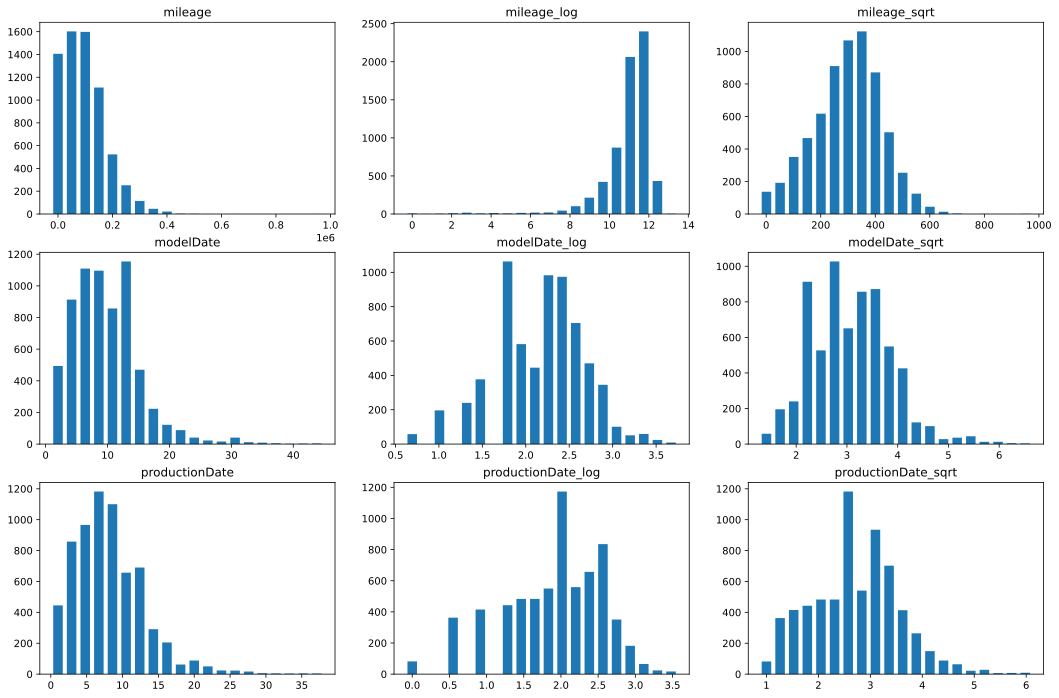

In [101]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage':  train['mileage'],
    'mileage_log':  np.log(train['mileage']).dropna(),
    'mileage_sqrt':  np.sqrt(train['mileage']).dropna(),
    'modelDate':  YEAR - train['modelDate'],
    'modelDate_log':  np.log(YEAR - train['modelDate']).dropna(),
    'modelDate_sqrt':  np.sqrt(YEAR - train['modelDate']).dropna(),
    'productionDate':  YEAR - train['productionDate'],
    'productionDate_log':  np.log(YEAR - train['productionDate']).dropna(),
    'productionDate_sqrt':  np.sqrt(YEAR - train['productionDate']).dropna(),
})

Для обработки mileage лучше взять квадратный корень, а для остальных логарифм

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [102]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color',  'fuelType', 'model_info', #'name','engineDisplacement', 'enginePower','Владение','ПТС','Руль',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы',  'Привод',  'xDrive']
  

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']
numerical_features_all = numerical_features + ['enginePower_num','engineDisplacement_num','Владение_num','prod-model']

In [103]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [104]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    df_output['Владельцы'].fillna('0', inplace=True)
    df_output['Владение'].fillna('-1', inplace=True)
    
    df_output['enginePower_num'] = df_output['enginePower'].apply(lambda x:x[:-4])
 #df_output['engineDisplacement_num'] = df_output['engineDisplacement'].apply(lambda x:int(float(x[:-4]) * 10 ) if x != 'undefined LTR' else 0) 
    df_output['engineDisplacement_num'] = df_output['engineDisplacement'].apply(lambda x:float(x[:-4]) if x != 'undefined LTR' else 0) 
    df_output['xDrive'] = df_output.apply(lambda x: x['name'].split(dir_transmissoin[x['vehicleTransmission']])[0].split(x['engineDisplacement'][:-4])[0], axis=1)
    


        ## 3. Столбец владение
    
    def num_of_months(row):
        if row['Владение']!='-1':
            list_ownership = row['Владение'].split()
            if len(list_ownership) == 2:
                if list_ownership[1] in ['год', 'года', 'лет']:
                    return int(list_ownership[0])*12
                return int(list_ownership[0])
            return int(list_ownership[0])*12 + int(list_ownership[3])
        else:
            if row['Владельцы'] == '3 или более':
                return (YEAR - row['productionDate'])*12/3
            elif row['Владельцы'] == '2 владельца':
                return (YEAR - row['productionDate'])*12/2
            else:
                return (YEAR - row['productionDate'])*12

    df_output['Владение_num'] = df_output.apply(num_of_months, axis=1)
    
    df_output['ПТС'] = df_output['ПТС'].map(lambda x:1 if x=='Оригинал' else 0 )
    df_output['Руль'] = df_output['Руль'].map(lambda x:1 if x=='Левый' else 0 )

    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей

        #корень пробега 
    df_output['mileage'] =  df_output['mileage'].map(lambda x: x**0.5)
    
    
    # Новые столбцы
        
    df_output['prod-model'] =df_output['modelDate'] - df_output['productionDate']
    df_output['modelDate'] = np.log(YEAR - df_output['modelDate'])
    df_output['productionDate'] = np.log(YEAR - df_output['productionDate'])

        # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features_all:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration','engineDisplacement','enginePower','name','Владение'], axis = 1, inplace=True)
    

    return df_output

In [105]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,modelDate,productionDate,ПТС,Руль,sample,price,enginePower_num,engineDisplacement_num,Владение_num,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,...,xDrive_269,xDrive_270,xDrive_271,xDrive_272,xDrive_273,xDrive_274,xDrive_275,xDrive_276,xDrive_277,xDrive_278,xDrive_279,xDrive_280,xDrive_281,xDrive_282,xDrive_283,xDrive_284,xDrive_285,xDrive_286,xDrive_287,xDrive_288,xDrive_289,xDrive_290,xDrive_291,xDrive_292,xDrive_293,xDrive_294,xDrive_295,xDrive_296,xDrive_297,xDrive_298,xDrive_299,xDrive_300,xDrive_301,xDrive_302,xDrive_303,xDrive_304,xDrive_305,xDrive_306,xDrive_307,prod-model
7399,0.326435,0.389193,0.489076,1,1,1,1590000.0,0.2720,0.303030,0.126411,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.944444
4273,0.211343,0.430677,0.439310,1,1,1,3100000.0,0.2720,0.303030,0.065463,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.833333
3362,0.233755,0.430677,0.489076,1,1,1,3750000.0,0.8160,0.833333,0.051919,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889
2794,0.352906,0.500000,0.628510,1,1,1,1990000.0,0.2720,0.454545,0.088036,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
5378,0.385391,0.430677,0.489076,1,1,1,1285000.0,0.2288,0.303030,0.051919,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889
5902,0.263460,0.467268,0.567601,1,1,1,3399999.0,0.7760,0.606061,0.214447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.944444
1454,0.228937,0.467268,0.489076,1,1,0,0.0,0.3920,0.454545,0.079007,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.833333
2476,0.415949,0.604531,0.700125,0,1,1,700000.0,0.2288,0.378788,0.092551,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.944444
743,0.345756,0.604531,0.654526,1,1,0,0.0,0.0640,0.242424,0.097065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.833333
1168,0.188926,0.467268,0.531153,1,1,0,0.0,0.7504,0.833333,0.060948,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889


In [106]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 496 entries, mileage to prod-model
dtypes: float64(8), int64(3), uint8(485)
memory usage: 4.6 MB


## Split data

In [107]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
#y = train_data.price.apply(lambda x: np.log(x)).values
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [108]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 495 entries, mileage to prod-model
dtypes: float64(8), int64(2), uint8(485)
memory usage: 935.0 KB


# Model 2: CatBoostRegressor

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [110]:
y_train_f = np.log(y_train)
y_test_f  = np.log(y_test)
y_f = np.log(y)

In [111]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.06,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train_f,
         eval_set=(X_test, y_test_f),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0403837	test: 0.0404160	best: 0.0404160 (0)	total: 4.17ms	remaining: 20.8s
100:	learn: 0.0099404	test: 0.0097633	best: 0.0097633 (100)	total: 362ms	remaining: 17.6s
200:	learn: 0.0088971	test: 0.0089557	best: 0.0089557 (200)	total: 723ms	remaining: 17.3s
300:	learn: 0.0082109	test: 0.0085339	best: 0.0085339 (300)	total: 1.09s	remaining: 17s
400:	learn: 0.0077600	test: 0.0082428	best: 0.0082428 (400)	total: 1.45s	remaining: 16.6s
500:	learn: 0.0074190	test: 0.0080780	best: 0.0080761 (497)	total: 1.82s	remaining: 16.3s
600:	learn: 0.0071986	test: 0.0079865	best: 0.0079865 (600)	total: 2.2s	remaining: 16.1s
700:	learn: 0.0069886	test: 0.0078903	best: 0.0078903 (700)	total: 2.57s	remaining: 15.8s
800:	learn: 0.0068274	test: 0.0078478	best: 0.0078475 (797)	total: 2.94s	remaining: 15.4s
900:	learn: 0.0066448	test: 0.0078065	best: 0.0078065 (900)	total: 3.31s	remaining: 15s
1000:	learn: 0.0064778	test: 0.0077740	best: 0.0077720 (995)	total: 3.67s	remaining: 14.7s
1100:	learn: 0.00

In [112]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
print(f"TEST mape round: {(mape(y_test, test_predict_catboost.round(-3)))*100:0.2f}%")
test_predict_catboost1 = np.exp(model.predict(X))
print(f"TEST mape all: {(mape(y, test_predict_catboost1))*100:0.2f}%")

TEST mape: 11.10%
TEST mape round: 11.10%
TEST mape all: 8.63%


In [113]:
ITERATIONS =5000
LR = 0.06
N_FOLDS = 10

from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

In [114]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              custom_metric=['RMSE', 'MAE'],
                              #depth =10,
                              random_seed = RANDOM_SEED,
                             # od_type='Iter',
                              od_wait =500,
                              )

    model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=False
         )    
    return(model)

In [115]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    Xf_train, yf_train, Xf_test, yf_test_true = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    yf_train = np.log(yf_train)
    yf_test =np.log(yf_test_true)
    # model for this fold
    model = cat_model(yf_train, Xf_train, Xf_test, yf_test,)
    # score model on test
    test_predict_catboostf = np.exp(model.predict(Xf_test)).round(-3)
    test_score = mape(yf_test_true, test_predict_catboostf)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(yf_test_true, test_predict_catboostf):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = np.exp(model.predict(X_sub))
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.5f}')
print(f'Std Score: {np.std(score_ls):0.5f}')
print(f'Max Score: {np.max(score_ls):0.5f}')
print(f'Min Score: {np.min(score_ls):0.5f}')

0:	learn: 0.0403820	test: 0.0410976	best: 0.0410976 (0)	total: 4.37ms	remaining: 21.8s
100:	learn: 0.0100060	test: 0.0096923	best: 0.0096923 (100)	total: 391ms	remaining: 19s
200:	learn: 0.0090249	test: 0.0089684	best: 0.0089684 (200)	total: 771ms	remaining: 18.4s
300:	learn: 0.0083249	test: 0.0084860	best: 0.0084860 (300)	total: 1.14s	remaining: 17.8s
400:	learn: 0.0078710	test: 0.0082046	best: 0.0082046 (400)	total: 1.51s	remaining: 17.4s
500:	learn: 0.0075434	test: 0.0080224	best: 0.0080224 (500)	total: 1.89s	remaining: 17s
600:	learn: 0.0072715	test: 0.0079023	best: 0.0079023 (600)	total: 2.26s	remaining: 16.5s
700:	learn: 0.0070587	test: 0.0078088	best: 0.0078088 (700)	total: 2.63s	remaining: 16.1s
800:	learn: 0.0068772	test: 0.0077639	best: 0.0077639 (800)	total: 3s	remaining: 15.7s
900:	learn: 0.0066956	test: 0.0077000	best: 0.0076997 (899)	total: 3.38s	remaining: 15.4s
1000:	learn: 0.0065445	test: 0.0076460	best: 0.0076455 (998)	total: 3.75s	remaining: 15s
1100:	learn: 0.006396

In [116]:
test_predict_catboost_f= model.predict(X)
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
print(f"TEST mape: {(mape(y, np.exp(test_predict_catboost_f)))*100:0.4f}%")
print(f"TEST mape: {(mape(y, np.exp(test_predict_catboost_f).round(-4)))*100:0.4f}%")

TEST mape: 6.38%
TEST mape: 7.2059%
TEST mape: 7.2073%


### Submission

In [117]:
#sub_predict_catboost = model.predict(X_sub)
#sub_predict_catboost = np.exp(model.predict(X_sub))
sub_predict_catboost = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(os.path.join(PATH,'submission',f'catboost_submission{ver}.csv'), index=False)
sub_predict_catboost 

0       7.491425e+05
1       2.708838e+06
2       6.263135e+05
3       4.925021e+05
4       2.664596e+06
            ...     
1666    1.077684e+06
1667    2.679968e+06
1668    1.518539e+06
1669    1.135698e+06
1670    1.040943e+06
Length: 1671, dtype: float64

# Model 3: Tabular NN

Построим обычную сеть:

In [118]:
X_train.head(5)

,mileage,modelDate,productionDate,ПТС,Руль,enginePower_num,engineDisplacement_num,Владение_num,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,...,xDrive_269,xDrive_270,xDrive_271,xDrive_272,xDrive_273,xDrive_274,xDrive_275,xDrive_276,xDrive_277,xDrive_278,xDrive_279,xDrive_280,xDrive_281,xDrive_282,xDrive_283,xDrive_284,xDrive_285,xDrive_286,xDrive_287,xDrive_288,xDrive_289,xDrive_290,xDrive_291,xDrive_292,xDrive_293,xDrive_294,xDrive_295,xDrive_296,xDrive_297,xDrive_298,xDrive_299,xDrive_300,xDrive_301,xDrive_302,xDrive_303,xDrive_304,xDrive_305,xDrive_306,xDrive_307,prod-model
7320,0.386685,0.581508,0.628510,1,1,0.7504,0.909091,0.250564,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.833333
8037,0.143857,0.284662,0.299875,1,1,0.2720,0.303030,0.079007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889
4681,0.365285,0.664849,0.739185,1,1,0.2880,0.469697,0.133183,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889
6014,0.574030,0.625965,0.720353,1,1,0.1744,0.272727,0.176072,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.944444
3649,0.354319,0.500000,0.567601,1,1,0.3808,0.454545,0.173815,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.888889


## Simple Dense NN

In [119]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [120]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               253440    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 385,025
Trainable params: 385,025
Non-trainable params: 0
_________________________________________________________________


In [121]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [122]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_model{ver}.hdf5') , monitor='val_MAPE', verbose=1  , mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [123]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/500
 1/12 [=>............................] - ETA: 0s - loss: 100.0000 - MAPE: 100.0000
Epoch 00001: val_MAPE improved from inf to 99.95564, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model16.hdf5
12/12 [==============================] - 1s 56ms/step - loss: 99.9943 - MAPE: 99.9943 - val_loss: 99.9556 - val_MAPE: 99.9556
Epoch 2/500
 1/12 [=>............................] - ETA: 0s - loss: 99.9566 - MAPE: 99.9566
Epoch 00002: val_MAPE improved from 99.95564 to 99.29240, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model16.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 99.7893 - MAPE: 99.7893 - val_loss: 99.2924 - val_MAPE: 99.2924
Epoch 3/500
 1/12 [=>............................] - ETA: 0s - loss: 99.2978 - MAPE: 99.2978
Epoch 00003: val_MAPE improved from 99.29240 to 96.06418, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/b

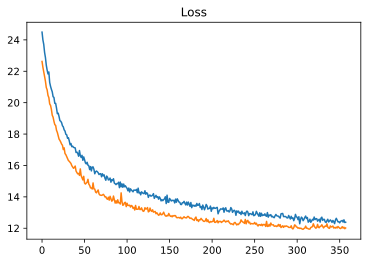

In [124]:
plt.title('Loss')
plt.plot(history.history['MAPE'][40:], label='train')
plt.plot(history.history['val_MAPE'][40:], label='test')
plt.show();

In [125]:
model.load_weights(os.path.join(PATH,'working',f'best_model{ver}.hdf5'))
model.save(os.path.join(PATH,'working',f'nn_1_{ver}.hdf5'))

In [126]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")
#print(f"TEST mape: {(mape(y_test_true, np.exp(test_predict_nn1[:,0]).round(-3)))*100:0.2f}%")
#print(f"TEST mape: {(mape(y_test_true, np.exp(test_predict_nn1[:,0])))*100:0.2f}%")

TEST mape: 11.93%


In [127]:
sub_predict_nn1 = model.predict(X_sub)
#sub_predict_nn1 = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv(os.path.join(PATH,'submission',f'nn1_submission_{ver}.csv'), index=False)
sub_predict_nn1

array([[ 606025.2 ],
       [2673789.  ],
       [ 638673.56],
       ...,
       [1487590.9 ],
       [1107891.6 ],
       [1027998.8 ]], dtype=float32)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [128]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [129]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [130]:
# split данных
text_train = data.description.iloc[X_train.index].map(lambda desc:re.sub('\n',' ',desc))
text_test = data.description.iloc[X_test.index].map(lambda desc:re.sub('\n',' ',desc))
text_sub = data.description.iloc[X_sub.index].map(lambda desc:re.sub('\n',' ',desc))

### Tokenizer

In [131]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description.map(lambda desc:re.sub('\n',' ',desc)))

CPU times: user 1.46 s, sys: 3.97 ms, total: 1.46 s
Wall time: 1.46 s


In [ ]:
#tokenize.word_index

In [133]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 1.27 s


In [134]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.  • Автомобиль проверен по 110 пунктам • Автокредит по специальной ставке от 13,7%  Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.  На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок. Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии. Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле. Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль. Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [135]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [136]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [137]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [138]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256, 256)     525312      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256)     0           lstm_2[0][0]                     
_______________________________________________________________________________________

### Fit

In [139]:
optimizer = tf.keras.optimizers.Adam(0.01) #0.01
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [140]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_model{ver}.hdf5'), monitor='val_MAPE', verbose=1, mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [141]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 99.9738 - MAPE: 99.9738
Epoch 00001: val_MAPE improved from inf to 99.69199, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model16.hdf5
12/12 [==============================] - 4s 358ms/step - loss: 99.9738 - MAPE: 99.9738 - val_loss: 99.6920 - val_MAPE: 99.6920
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 97.4473 - MAPE: 97.4473
Epoch 00002: val_MAPE improved from 99.69199 to 88.97865, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model16.hdf5
12/12 [==============================] - 4s 325ms/step - loss: 97.4473 - MAPE: 97.4473 - val_loss: 88.9786 - val_MAPE: 88.9786
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 69.6449 - MAPE: 69.6449
Epoch 00003: val_MAPE improved from 88.97865 to 52.04691, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/b

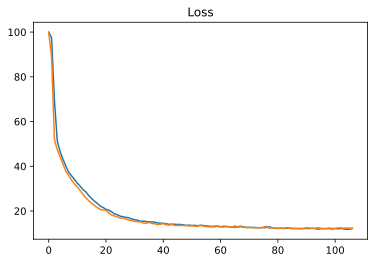

In [142]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [145]:
optimizer = tf.keras.optimizers.Adam(0.001) #0.01
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [146]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 11.3671 - MAPE: 11.3671
Epoch 00001: val_MAPE did not improve from 11.84579
12/12 [==============================] - 4s 317ms/step - loss: 11.3671 - MAPE: 11.3671 - val_loss: 11.8490 - val_MAPE: 11.8490
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 11.3577 - MAPE: 11.3577
Epoch 00002: val_MAPE improved from 11.84579 to 11.83727, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model16.hdf5
12/12 [==============================] - 3s 284ms/step - loss: 11.3577 - MAPE: 11.3577 - val_loss: 11.8373 - val_MAPE: 11.8373
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 11.3517 - MAPE: 11.3517
Epoch 00003: val_MAPE did not improve from 11.83727
12/12 [==============================] - 3s 231ms/step - loss: 11.3517 - MAPE: 11.3517 - val_loss: 11.8681 - val_MAPE: 11.8681
Epoch 4/500
12/12 [==============================] - ETA: 0s - loss: 11.1

In [ ]:
model.load_weights(os.path.join(PATH,f'working',f'best_model{ver}.hdf5'))
model.save(os.path.join(PATH,'working',f'nn_mlp_nlp_{ver}.hdf5'))

In [147]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
#test_predict_nn2 = np.exp(model.predict([text_test_sequences, X_test])).round(-3)

print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.83%
TEST mape: 11.83%


In [148]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
#sub_predict_nn2 = np.exp(model.predict([text_sub_sequences, X_sub]))
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv(os.path.join(PATH,'submission',f'nn2_submission{ver}.csv'), index=False)
sub_predict_nn2

array([[ 555869.25],
       [2620115.  ],
       [ 640170.7 ],
       ...,
       [1481723.  ],
       [1114783.6 ],
       [1098453.2 ]], dtype=float32)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

In [ ]:
# what_is = os.listdir(DATA_DIR+'/img')
# train.'sell_id'.map(lambda x: if  )

### Data

In [149]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
#for data_zip in ['img.zip']:
with zipfile.ZipFile(DATA_DIR + '/img.zip',"r") as z:    
        z.extractall(WORK_PATH)
        
print(os.listdir(WORK_PATH))

Распаковываем картинки
['img', '__MACOSX']


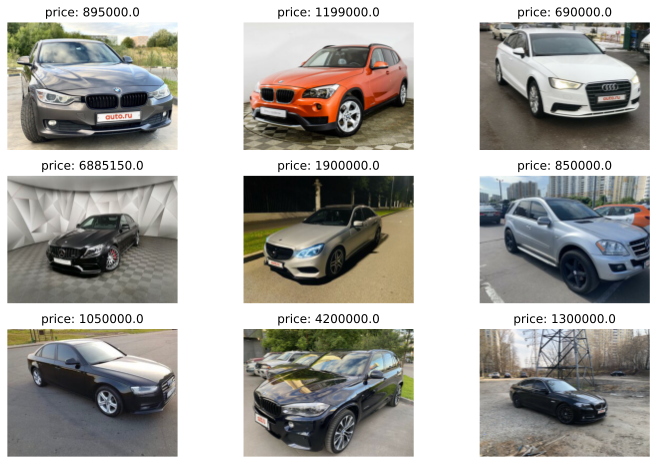

In [150]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path_ in enumerate(random_image_paths):
    im = PIL.Image.open(WORK_PATH + '/img/' + str(path_) + '.jpg')
#        im = PIL.Image.open(DATA_DIR+'/img/' + str(path_) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [151]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(WORK_PATH + '/img/' + str(sell_id) + '.jpg')
  #              image = cv2.imread(DATA_DIR + '/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

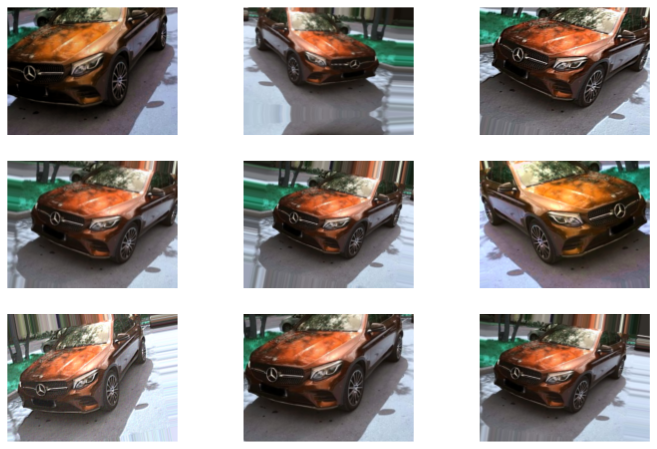

In [152]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
   # ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1), #0.1
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15,border_mode=cv2.BORDER_REPLICATE,p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
     #   IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[1])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [153]:

# #пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
# augmentation = Compose([
#     #HorizontalFlip(),
#     #OneOf([IAAAdditiveGaussianNoise(), GaussNoise(), ], p=1),
#     #OneOf([MotionBlur(p=0.2), MedianBlur(blur_limit=3, p=0.1),Blur(blur_limit=3, p=0.1),], p=0.2),
#     #ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15,border_mode=cv2.BORDER_REPLICATE, p=1),
#    # OneOf([OpticalDistortion(p=0.3), GridDistortion(p=0.1), IAAPiecewiseAffine(p=0.3),  ], p=1),
#     OneOf([OpticalDistortion(p=0.3), GridDistortion(p=0.1),  ], p=1),
#     #OneOf([ CLAHE(clip_limit=2), IAASharpen(), IAAEmboss(),RandomBrightnessContrast(), ], p=0.3),
#     #HueSaturationValue(p=0.3),
#     ], p=1)

# #пример
# plt.figure(figsize = (12,8))
# for i in range(9):
#     img_1 = images_train[0]
#     img = augmentation(image = img_1)['image']
    
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(img)
#     plt.axis('off')
# plt.show()



In [154]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [155]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [156]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [157]:
def tf_process_train_dataset_element_img(image,  price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return (image), price

def tf_process_val_dataset_element_img(image,  price):
    return (image), price

train_dataset_img = tf.data.Dataset.from_tensor_slices((
    images_train, y_train
    )).map(tf_process_train_dataset_element_img)

test_dataset_img = tf.data.Dataset.from_tensor_slices((
    images_test,  y_test
    )).map(tf_process_val_dataset_element_img)

train_dataset_img.__iter__().__next__();
test_dataset_img.__iter__().__next__();    

### Строим сверточную сеть для анализа изображений без "головы"

In [158]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3),  drop_connect_rate=0.4)                                                                
#efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [159]:
# Устанавливаем новую "голову" (head)
efficientnet_model.training=False

x = efficientnet_model.output
x = L.GlobalAveragePooling2D()(x)

x = L.Dense(100, activation='relu')(x)
x = L.Dropout(0.25)(x)

predictions = L.Dense(1, )(x)

# this is the model we will train
model_img = Model(inputs=efficientnet_model.input, outputs=predictions)

In [160]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_model_img_{ver}.hdf5'), monitor='val_MAPE', verbose=1, mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [161]:
%%time
# заморозим BatchNorm слои
# for layer in model.layers:
#         if  isinstance(layer, BatchNormalization):
#             layer.trainable  =  False 
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

#model_img.compile(loss="MAPE", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=['MAPE'])
model_img.compile(loss='MAPE',optimizer=tf.keras.optimizers.Adam(0.005), metrics=['MAPE'])
# Загрузим ранее вычисленные веса
#model.load_weights(os.path.join(DIR, f'best_model/best_model7_1.hdf5'))

history =    model_img.fit(
        train_dataset_img.batch(30),
        epochs=100,
        validation_data = test_dataset_img.batch(30),
        callbacks = callbacks_list
       )
    
    # сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

# model_img.load_weights(os.path.join(PATH,'working',f'best_model_img_{ver}.hdf5'))
# model_img.save(os.path.join(PATH,'working',f'nn_img{ver}.hdf5'))

Epoch 1/100
190/190 [==============================] - ETA: 0s - loss: 95.9154 - MAPE: 95.9154
Epoch 00001: val_MAPE improved from inf to 78.31060, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model_img_16.hdf5
190/190 [==============================] - 114s 602ms/step - loss: 95.9154 - MAPE: 95.9154 - val_loss: 78.3106 - val_MAPE: 78.3106
Epoch 2/100
190/190 [==============================] - ETA: 0s - loss: 66.1376 - MAPE: 66.1376
Epoch 00002: val_MAPE did not improve from 78.31060
190/190 [==============================] - 108s 570ms/step - loss: 66.1376 - MAPE: 66.1376 - val_loss: 887.6564 - val_MAPE: 887.6564
Epoch 3/100
190/190 [==============================] - ETA: 0s - loss: 50.2110 - MAPE: 50.2110
Epoch 00003: val_MAPE improved from 78.31060 to 50.11116, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model_img_16.hdf5
190/190 [==============================] - 111s 584ms/step - loss: 5

In [162]:
model_img.load_weights(os.path.join(PATH,'working',f'best_model_img_{ver}.hdf5'))
model_img.save(os.path.join(PATH,'working',f'nn_img{ver}.hdf5'))

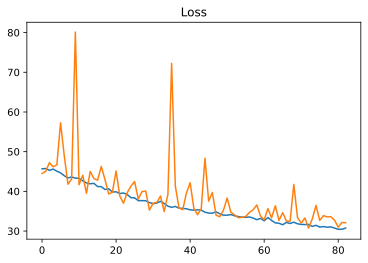

In [163]:
plt.title('Loss')
plt.plot(history.history['MAPE'][12:], label='train')
plt.plot(history.history['val_MAPE'][12:], label='test')
plt.show();

In [164]:
#model_img.load_weights(os.path.join(PATH,'working',f'best_model_img_53.hdf5'))

In [165]:
test_predict_img = model_img.predict(test_dataset.batch(30))
#test_predict_img = np.exp(test_predict_img[:,0]).round(-3) 
#print(f"TEST mape: {(mape(y_test_true, test_predict_img))*100:0.2f}%")
print(f"TEST mape: {(mape(y_test, test_predict_img[:,0]))*100:0.2f}%")

TEST mape: 30.42%


In [166]:
#ver =12

In [167]:
efficientnet_output = model_img.output #L.GlobalAveragePooling2D()(efficientnet_model.output)

In [168]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
# efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3),  drop_connect_rate=0.4)                                                                
# efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [169]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [170]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [171]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.25)(head) #0.25
head = L.Dense(128, activation="relu")(head)#
head = L.Dropout(0.25)(head) #
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
#model.summary()

In [172]:
optimizer = tf.keras.optimizers.Adam(0.005) #0.005
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [173]:
#ver = 11
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_model{ver}.hdf5'), monitor='val_MAPE', verbose=1, mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [174]:
%%time
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - ETA: 0s - loss: 34.9068 - MAPE: 34.9068
Epoch 00001: val_MAPE improved from inf to 33.43892, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model12.hdf5
190/190 [==============================] - 126s 662ms/step - loss: 34.9068 - MAPE: 34.9068 - val_loss: 33.4389 - val_MAPE: 33.4389
Epoch 2/100
190/190 [==============================] - ETA: 0s - loss: 31.3189 - MAPE: 31.3189
Epoch 00002: val_MAPE improved from 33.43892 to 28.36924, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_model12.hdf5
190/190 [==============================] - 120s 629ms/step - loss: 31.3189 - MAPE: 31.3189 - val_loss: 28.3692 - val_MAPE: 28.3692
Epoch 3/100
190/190 [==============================] - ETA: 0s - loss: 28.5652 - MAPE: 28.5652
Epoch 00003: val_MAPE improved from 28.36924 to 27.01188, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMo

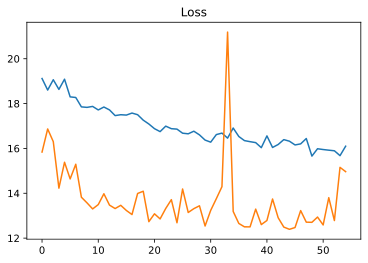

In [175]:
plt.title('Loss')
plt.plot(history.history['MAPE'][12:], label='train')
plt.plot(history.history['val_MAPE'][12:], label='test')
plt.show();

In [176]:
#model.load_weights(os.path.join(PATH,'working',f'best_model0.hdf5'))

In [177]:
model.load_weights(os.path.join(PATH,'working',f'best_model{ver}.hdf5'))
model.save(os.path.join(PATH,'working',f'nn_final{ver}.hdf5'))

In [178]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
#test_predict_nn3 = np.exp(test_predict_nn3[:,0]).round(-3)
#print(f"TEST mape: {(mape(y_test_true, test_predict_nn3))*100:0.2f}%")
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.39%


In [179]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
#sample_submission['price'] = np.exp(sub_predict_nn3[:,0])
sample_submission.to_csv(os.path.join(PATH,'submission',f'nn3_submission_{ver}.csv'), index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [1]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")
print(f"TEST mape: {(mape(y_test, blend_predict.round(-3)))*100:0.2f}%")

NameError: ignored

In [181]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
#blend_sub_predict = (sub_predict_catboost + np.exp(sub_predict_nn3[:,0])/2
sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission{ver}.csv'), index=False)
sample_submission['price']

0        661000.0
1       2747000.0
2        643000.0
3        524000.0
4       2748000.0
          ...    
1666    1028000.0
1667    2695000.0
1668    1446000.0
1669    1134000.0
1670    1042000.0
Name: price, Length: 1671, dtype: float64

In [182]:
sub_predict_nn3[:,0], test_predict_catboost

(array([ 573336.94, 2784358.2 ,  659695.3 , ..., 1372479.4 , 1132700.8 ,
        1043947.1 ], dtype=float32),
 array([ 550633.56288405,  904032.31433442, 1199164.7251944 , ...,
         607707.05426236,  896933.30851911, 1005287.77069904]))

# Model Bonus: проброс признака

In [183]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [184]:
# FEATURE Input
# Input
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [185]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [186]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_24_input (InputLayer)     [(None, 494)]        0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 512)          253440      dense_24_input[0][0]             
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 512)          0           dense_24[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [187]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [188]:
checkpoint = ModelCheckpoint(os.path.join(PATH,'working',f'best_modelb{ver}.hdf5'), monitor='val_MAPE', verbose=1, mode='min', save_best_only = True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [189]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
 1/12 [=>............................] - ETA: 0s - loss: 100.0000 - MAPE: 100.0000
Epoch 00001: val_MAPE improved from inf to 99.79642, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_modelb12.hdf5
12/12 [==============================] - 1s 75ms/step - loss: 99.9832 - MAPE: 99.9832 - val_loss: 99.7964 - val_MAPE: 99.7964
Epoch 2/500
 1/12 [=>............................] - ETA: 0s - loss: 99.8063 - MAPE: 99.8063
Epoch 00002: val_MAPE improved from 99.79642 to 92.02198, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working/best_modelb12.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 98.1937 - MAPE: 98.1937 - val_loss: 92.0220 - val_MAPE: 92.0220
Epoch 3/500
 1/12 [=>............................] - ETA: 0s - loss: 91.9420 - MAPE: 91.9420
Epoch 00003: val_MAPE improved from 92.02198 to 50.47838, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/BatMobile/working

In [190]:
model.load_weights(os.path.join(PATH,'working',f'best_modelb{ver}.hdf5'))
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")
#print(f"TEST mape: {(mape(y_test_true, np.exp(test_predict_nn_bonus[:,0]).round(-3)))*100:0.2f}%")

TEST mape: 12.07%


In [191]:
#blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn_bonus[:,0]) / 3
blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn1[:,0]) / 3
print(f"TEST mape with nn1: {(mape(y_test, blend_predict))*100:0.2f}%")
blend_predict = (test_predict_catboost + test_predict_nn3[:,0] + test_predict_nn_bonus[:,0]) / 3
print(f"TEST mape with bonus: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape with nn1: 9.67%
TEST mape with bonus: 9.69%


In [192]:
sub_predict_nn_bonus = model.predict([X_sub, X_sub.productionDate.values])
sample_submission['price'] = sub_predict_nn_bonus[:,0]
#sample_submission['price'] =np.exp(sample_submission['price'])

sample_submission.to_csv(os.path.join(PATH,'submission',f'nn_bonus_submission_{ver}.csv'), index=False)

In [193]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0] + sub_predict_nn_bonus[:,0]) / 3

#blend_sub_predict = (np.exp(sub_predict_catboost) + np.exp(sub_predict_nn3[:,0]) + np.exp(sub_predict_nn_bonus[:,0])) / 3
sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission_bonus{ver}.csv'), index=False)

In [194]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0] + sub_predict_nn1[:,0]) / 3

#blend_sub_predict = (np.exp(sub_predict_catboost) + np.exp(sub_predict_nn3[:,0]) + np.exp(sub_predict_nn_bonus[:,0])) / 3
sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission_nn1{ver}.csv'), index=False)

In [18]:
ver =ver*10
df_nn3 = pd.read_csv(os.path.join(os.path.join(PATH,'submission','nn3_submission_10.csv')))['price']
#df_nn3 = sub_predict_nn3[:,0]
df_cat =  pd.read_csv(os.path.join(PATH,'submission',f'catboost_submission11.csv'))['price']
df_nn1 = pd.read_csv(os.path.join(os.path.join(PATH,'submission','nn1_submission_11.csv')))['price']
#df_nn1 = sub_predict_nn1[:,0]
#df_nn2 = pd.read_csv(os.path.join(os.path.join(PATH,'submission','nn2_submission16.csv')))['price']

In [19]:
blend_sub_predict = (df_cat + df_nn3 + df_nn1) / 3
#blend_sub_predict = (df_cat + df_nn3 + df_nn1 + df_nn2) / 4

#blend_sub_predict = (np.exp(sub_predict_catboost) + np.exp(sub_predict_nn3[:,0]) + np.exp(sub_predict_nn_bonus[:,0])) / 3
sample_submission['price'] = blend_sub_predict.round(-3)
sample_submission.to_csv(os.path.join(PATH,'submission',f'blend_submission_nn0{ver}.csv'), index=False)

In [20]:
#df['price'],sub_predict_nn1,
sample_submission

,sell_id,price
0,1099427284,618000.0
1,1096405886,2626000.0
2,1100195294,608000.0
3,1099827282,522000.0
4,1100076198,2748000.0
...,...,...
1666,1099414488,1022000.0
1667,1099277058,2647000.0
1668,1098773964,1474000.0
1669,1098835932,1125000.0
